**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Multi-modal modeling**

**Preparation of data**

In [2]:
# Import necessary libraries (ライブラリのインポート)
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the stats CSV file (スタッツCSVの読み込み)
df_stats = pd.read_csv('/content/drive/MyDrive/MIT_Sloan/position_stats_mean_per_min_small_class.csv')

# Drop rows where 'small_class' is missing (small_classが欠損している行を削除)
df_stats = df_stats.dropna(subset=['small_class'])

# Apply Label Encoding (ラベルエンコード)
le = LabelEncoder()
df_stats['target'] = le.fit_transform(df_stats['small_class'])

# Extract stats columns (スタッツ列抽出)
feature_cols = [col for col in df_stats.columns if col.endswith('_per_min')]

# Fill NaN with 0 and convert to numpy array (欠損値を0で埋め、NumPy配列に変換)
X_stats_raw = df_stats[feature_cols].fillna(0).to_numpy()

# Extract the target variable (ターゲット変数を抽出)
y_all = df_stats['target'].to_numpy()

# Standardize the stats (スタッツの標準化)
scaler = StandardScaler()
X_stats_scaled = scaler.fit_transform(X_stats_raw)

# Weight the stats (tentative: initialized to 1.0, adjust as needed) (スタッツの重み付け（仮の例：すべて1.0で初期化、必要に応じて調整）)
feature_weights = np.ones(X_stats_scaled.shape[1])
X_stats_weighted = X_stats_scaled * feature_weights

# Define the image folder path (画像ファイルの読み込み)
image_folder = '/content/drive/MyDrive/heatmaps_11cluster'

# Get all image file paths (全ての画像ファイルのパスを取得)
image_files = glob.glob(os.path.join(image_folder, '*', 'pass_heatmap_match_*.png'))

# Synchronize stats and images (スタッツと画像の同期)
stats_map = {}
for idx, row in df_stats.iterrows():
    # Create a unique key (一意のキーを作成)
    key = f"{int(row['match_id'])}_{int(row['player_id'])}"
    stats_map[key] = {
        'stats': X_stats_weighted[idx],
        'label': y_all[idx]
    }

# Initialize lists for image and stats data (画像とスタッツのデータリストを初期化)
X_img, X_stats, y = [], [], []

for f in image_files:
    # Split the filename to extract IDs (ファイル名を分割してIDを抽出)
    parts = os.path.basename(f).split('_')
    if len(parts) >= 6:
        match_id = parts[3]
        player_id_raw = parts[5].replace('.png', '')

        # Clean and convert player_id (player_idをクリーンにして整数に変換)
        player_id = str(int(float(player_id_raw)))
        key = f"{match_id}_{player_id}"

        if key in stats_map:
            # Read and decode the image file (画像ファイルを読み込み、デコード)
            img_data = tf.io.read_file(f)
            img_data = tf.io.decode_png(img_data, channels=3)

            # Resize and normalize the image (画像のサイズ変更と正規化)
            img_data = tf.image.resize(img_data, [224, 224])
            img_data = img_data.numpy() / 255.0

            # Append data to lists (リストにデータを追加)
            X_img.append(img_data)
            X_stats.append(stats_map[key]['stats'])
            y.append(stats_map[key]['label'])

# Convert to NumPy arrays (NumPy配列に変換)
X_img = np.array(X_img)
X_stats = np.array(X_stats)
y = np.array(y)

# Split the data (データ分割)
X_train_img, X_test_img, X_train_stats, X_test_stats, y_train, y_test = train_test_split(
    X_img, X_stats, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Image and stats data successfully synchronized and split.（同期済み画像・スタッツデータの分割が完了しました）")

# Attention block for stats (スタッツ用Attentionブロック)
from tensorflow.keras.layers import Dense, Multiply

def stats_attention(x):
    # Calculate attention weights (Attentionの重みを計算)
    attention_weights = Dense(x.shape[-1], activation='softmax')(x)

    # Apply weights to the input features (入力特徴量に重みを適用)
    return Multiply()([x, attention_weights])

✅ 同期済み画像・スタッツデータの分割が完了しました。


マルチモーダルの実装

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stats_input         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      1,472 │ stats_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 86528)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 11,075,712 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128)       │          0 │ dense_2[0][0],    │
│ (Multiply)          │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ multiply[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,213,195 (42.77 MB)

 Trainable params: 11,213,195 (42.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.2139 - loss: 2.3438 - val_accuracy: 0.5929 - val_loss: 1.3783 - learning_rate: 0.0010
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.5034 - loss: 1.5326 - val_accuracy: 0.7596 - val_loss: 0.8091 - learning_rate: 0.0010
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.6787 - loss: 1.0844 - val_accuracy: 0.7692 - val_loss: 0.7277 - learning_rate: 0.0010
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.7251 - loss: 0.9393 - val_accuracy: 0.7596 - val_loss: 0.6989 - learning_rate: 0.0010
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.7540 - loss: 0.7593 - val_accuracy: 0.7532 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.7819 - loss: 0.6691 - val_accuracy: 0.7468 - val_loss: 0.7013 - learning_rate: 0.0010
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7928 - loss: 0.5839
Epoch 7: Re

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

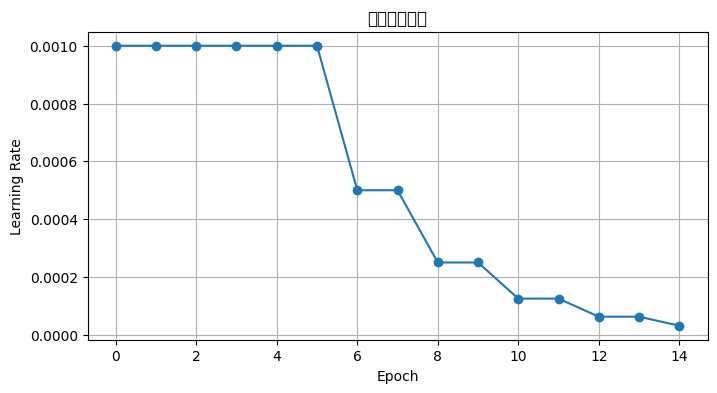

In [3]:
# Import necessary libraries (必要なライブラリのインポート)
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt

# Define input layers (入力定義)
image_input = Input(shape=(224, 224, 3), name='image_input')  # Image input (画像入力)
stats_input = Input(shape=(X_stats.shape[1],), name='stats_input')  # Stats input (スタッツ入力)

# CNN block for image processing (CNNブロック（画像処理）)
x_img = Conv2D(32, (3, 3), activation='relu')(image_input)
x_img = MaxPooling2D((2, 2))(x_img)
x_img = Conv2D(64, (3, 3), activation='relu')(x_img)
x_img = MaxPooling2D((2, 2))(x_img)
x_img = Conv2D(128, (3, 3), activation='relu')(x_img)
x_img = MaxPooling2D((2, 2))(x_img)
x_img = Flatten()(x_img)
x_img = Dense(128, activation='relu')(x_img)
x_img = Dropout(0.5)(x_img)

# MLP block for stats processing (MLPブロック（スタッツ処理）)
x_stats = Dense(64, activation='relu')(stats_input)
x_stats = Dropout(0.3)(x_stats)
x_stats = Dense(128, activation='relu')(x_stats)

# Gated fusion mechanism (ゲート付き融合機構)
gate = Dense(128, activation='sigmoid')(x_stats)  # Gating vector from stats (スタッツからのゲートベクトル)
x_img_gated = Multiply()([x_img, gate])  # Apply gate to image features (画像特徴にゲートを適用)
gate_inv = tf.keras.layers.Lambda(lambda x: 1.0 - x)(gate)  # Inverse gate (ゲートの反転)
x_stats_gated = Multiply()([x_stats, gate_inv])  # Apply inverse gate to stats (スタッツに反転ゲートを適用)
x_fused = Add()([x_img_gated, x_stats_gated])  # Fuse gated features (ゲート付き特徴の融合)

# Output layer (出力層)
x = Dense(128, activation='relu')(x_fused)
x = Dropout(0.5)(x)
output = Dense(11, activation='softmax')(x)  # 11-class classification (11クラス分類)

# Define and compile the model (モデル定義とコンパイル)
model = Model(inputs=[image_input, stats_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callback to record learning rate per epoch (学習率記録用コールバック)
class LrHistory(Callback):
    def on_train_begin(self, logs=None):
        self.lr_values = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if hasattr(lr, 'numpy'):
            self.lr_values.append(lr.numpy())
        else:
            self.lr_values.append(tf.keras.backend.get_value(lr))

lr_history = LrHistory()

# Learning rate scheduler (ReduceLROnPlateau) (学習率調整コールバック)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss (検証損失を監視)
    factor=0.5,          # Reduce LR by half (学習率を半分に)
    patience=2,          # Wait 2 epochs before reducing (2エポック待機)
    verbose=1,
    min_lr=1e-6          # Minimum learning rate (最小学習率)
)

# Train the model (モデル学習)
history = model.fit(
    [X_train_img, X_train_stats], y_train,
    validation_data=([X_test_img, X_test_stats], y_test),
    epochs=15,
    batch_size=32,
    callbacks=[lr_scheduler, lr_history]
)

# Visualize learning rate changes (学習率の推移を可視化)
plt.figure(figsize=(8, 4))
plt.plot(lr_history.lr_values, marker='o')
plt.title("Learning Rate Schedule (学習率の推移)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

**Prediction**

In [6]:
# Classification Report for Multimodal Model (マルチモーダルモデルの分類レポート出力)

from sklearn.metrics import classification_report

# Predict class probabilities using the trained model (学習済みモデルによるSoftmax確率の予測)
y_pred_probs = model.predict([X_test_img, X_test_stats])

# Convert probabilities to class labels (確率をクラスラベルに変換)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Define class names (11 football positions) (クラス名（11ポジション）を定義)
target_names = ['CMF', 'GK', 'LCB', 'LFB', 'LWB', 'LWG', 'RCB', 'RFB', 'RWB', 'RWG', 'ST']

# Generate classification report (分類レポートの生成)
report = classification_report(y_test, y_pred_classes, target_names=target_names, output_dict=True)

# Display key metrics (主要指標の表示：AccuracyとMacro F1-score)
print("Accuracy:", round(report['accuracy'], 3))
print("Macro F1-score:", round(report['macro avg']['f1-score'], 3))


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Accuracy: 0.766
Macro F1-score: 0.689


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Classification report / 分類レポート
print("📊 Classification Report:")
report = classification_report(y_test, y_pred_classes, target_names=target_names, output_dict=True)
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"{label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}")

# Confusion matrix / 混同行列
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\n🧩 Confusion Matrix:")
print(conf_matrix)

# Accuracy per class / クラスごとの正解率
print("\n🎯 Accuracy per class:")
for i in range(conf_matrix.shape[0]):
    correct = conf_matrix[i, i]
    total = np.sum(conf_matrix[i, :])
    acc = correct / total if total > 0 else 0
    print(f"{target_names[i]}: Accuracy = {acc:.2f}")

# Specificity and False Positive Rate / 特異度と偽陽性率
print("\n🔍 Specificity and 🚫 False Positive Rate per class:")
for i in range(conf_matrix.shape[0]):
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(conf_matrix[i, :], i))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"{target_names[i]}: Specificity = {specificity:.2f}, FPR = {fpr:.2f}")

# ROC AUC curves / ROC AUC曲線の描画
num_classes = y_pred_probs.shape[1]
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{target_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Generate classification report as dictionary
# 分類レポートを辞書形式で取得
mm_report = classification_report(y_test, y_pred_classes, output_dict=True)

# Extract key performance metrics from report
# レポートから主要な精度指標を抽出
mm_metrics = {
    'Model': 'CNN',  # モデル名
    'Accuracy': round(mm_report['accuracy'], 3),  # 全体の正解率
    'Macro Precision': round(mm_report['macro avg']['precision'], 3),  # マクロ平均の適合率
    'Macro Recall': round(mm_report['macro avg']['recall'], 3),  # マクロ平均の再現率
    'Macro F1-score': round(mm_report['macro avg']['f1-score'], 3),  # マクロ平均のF1スコア
    'Weighted Precision': round(mm_report['weighted avg']['precision'], 3),  # 重み付き平均の適合率
    'Weighted Recall': round(mm_report['weighted avg']['recall'], 3),  # 重み付き平均の再現率
    'Weighted F1-score': round(mm_report['weighted avg']['f1-score'], 3)  # 重み付き平均のF1スコア
}

# Convert metrics to DataFrame for display
# 精度指標をデータフレームに変換して表示
df_mm_metrics = pd.DataFrame([mm_metrics])

# Display metrics for MIT paper
# MIT論文用に精度指標を表示
print("📊 Multimodalモデル精度指標（MIT論文用）")
display(df_mm_metrics)

📊 Multimodalモデル精度指標（MIT論文用）


,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-score,Weighted Precision,Weighted Recall,Weighted F1-score
0,CNN,0.766,0.749,0.683,0.689,0.777,0.766,0.76
